In [1]:
from keras.models import Sequential, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers.crf import CRF
from keras_contrib.utils import save_load_utils
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
import pickle, os

Using TensorFlow backend.


In [2]:
BERT_BASE = os.path.join(os.getcwd(), 'bert/bert_model/uncased_L-12_H-768_A-12')

In [3]:
from utils import *

In [4]:
class LSTMmodel:
    def __init__(self, input_length, para_emb_dim, num_tags, hidden_dim=200, dropout=0.5):
        self.num_tags = num_tags
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(input_length, para_emb_dim)))
        self.model.add(Dropout(dropout))
        # self.model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(input_length, para_emb_dim)))
        # self.model.add(Dropout(dropout))
        self.model.add(TimeDistributed(Dense(self.num_tags)))
        crf = CRF(self.num_tags)
        self.model.add(crf)
        self.model.compile('rmsprop', loss=crf_loss, metrics=[crf_accuracy])
    
    def save_model(self, filepath):
        save_load_utils.save_all_weights(self.model, filepath)
    
    def restore_model(self, filepath):
        save_load_utils.load_all_weights(self.model, filepath)
        
    def train(self, trainX, trainY, batch_size=32, epochs=10, validation_split=0.1, verbose=1):
        return self.model.fit(trainX, np.array(trainY), batch_size=batch_size, epochs=epochs, 
                             validation_split=validation_split, verbose=verbose)
    
    @staticmethod
    def myloss(y_true, y_pred):   
        y_pred /= tf.reduce_sum(y_pred, -1, True)
        # manual computation of crossentropy
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        return -tf.reduce_sum(y_true * tf.log(y_pred), -1)
        

In [5]:
# from Dataprocessor import Dataprocessor

# filelist = [('data/%d.json' % i) for i in range(500)]
# processor = Dataprocessor()
# train_texts, train_tags, train_rawtags = processor.load_data(filelist)

# save_train_data(train_texts, train_tags, train_rawtags)
train_texts, train_tags, train_rawtags = load_train_data()
print(len(train_texts), len(train_tags), len(train_rawtags))

114975 114975 114975


In [6]:
count_dic = {}
_sum = 0
for tags in train_tags:
    for t in tags:
        if t not in count_dic:
            count_dic[t] = 1
        else:
            count_dic[t] += 1
        _sum += 1

print(count_dic)

weight_dic = {}
for tag in count_dic:
    weight_dic[tag] = float(int(min(1 / (count_dic[tag] / _sum), 100)))
weight_dic[0] = 0.0
print(weight_dic)

{1: 718948, 2: 211986, 10: 2908756, 11: 708325, 6: 105894, 3: 15923, 7: 6231, 4: 344, 8: 201, 5: 55, 9: 2}
{1: 6.0, 2: 22.0, 10: 1.0, 11: 6.0, 6: 44.0, 3: 100.0, 7: 100.0, 4: 100.0, 8: 100.0, 5: 100.0, 9: 100.0, 0: 0.0}


In [7]:
from bert_utils import BERTmodel

bert_config_file = os.path.join(BERT_BASE, 'bert_config.json')
vocab_file = os.path.join(BERT_BASE, 'vocab.txt')
bert_checkpoint = os.path.join(BERT_BASE, 'bert_model.ckpt')
    
# feature = get_all_features(train_texts[:], bert_config_file, vocab_file, bert_checkpoint)
# with open('save_model/feature_1.pk', 'rb') as f:
#     feature = pickle.load(f)
# print(len(feature))


In [15]:
INPUT_LENGTH = 100
PARAGRAPH_EMB_DIM = 768
NUM_TAGS = 12

model = LSTMmodel(INPUT_LENGTH, PARAGRAPH_EMB_DIM, NUM_TAGS)
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100, 400)          1550400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 400)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 12)           4812      
_________________________________________________________________
crf_3 (CRF)                  (None, 100, 12)           324       
Total params: 1,555,536
Trainable params: 1,555,536
Non-trainable params: 0
_________________________________________________________________


In [9]:
def get_train(i):
    with open('save_model/feature_%d.pk' % i, 'rb') as f:
        feature = pickle.load(f)
    
    tags = train_tags[i*5000:(i+1)*5000]
    
    X, rawY = [], [] # X is 3D: article, paragraph, embedding; Y is 2D: article, paragraph
    for f, t in zip(feature, tags):
        while len(f) < INPUT_LENGTH:
            f.append(np.zeros(PARAGRAPH_EMB_DIM))
        while len(t) < INPUT_LENGTH:
            t.append(0)
        f = f[0:INPUT_LENGTH]
        t = t[0:INPUT_LENGTH]
        X.append(f)
        rawY.append(t)
    
    Y = [to_categorical(y, num_classes=NUM_TAGS) for y in rawY] # Y is now 3D
    return X, Y

        
def get_test(i):
    with open('save_model/feature_%d.pk' % i, 'rb') as f:
        feature = pickle.load(f)
    tags = train_tags[i*5000:(i+1)*5000]
    X, rawY = [], [] # X is 3D: article, paragraph, embedding; Y is 2D: article, paragraph
    for f, t in zip(feature, tags):
        while len(f) < INPUT_LENGTH:
            f.append(np.zeros(PARAGRAPH_EMB_DIM))
        while len(t) < INPUT_LENGTH:
            t.append(0)
        f = f[0:INPUT_LENGTH]
        t = t[0:INPUT_LENGTH]
        X.append(f)
        rawY.append(t)
    
    Y = [to_categorical(y, num_classes=NUM_TAGS) for y in rawY] # Y is now 3D
    return X, Y

In [10]:
testPickleID = 12
testX, testY = get_test(testPickleID)
def test_accuracy(X=testX, Y=testY):
    # Predict on test
    test_pred = model.model.predict(np.array(X), verbose=1)
    truecnt = 0
    falsecnt = 0
    _max = 0
    _maxarg = 0
    for (i, pred) in enumerate(test_pred):
        tcnt = 0
        fcnt = 0
        for j, p in enumerate(pred):
            if np.argmax(Y[i][j]) != 0:
                if np.argmax(p) == np.argmax(Y[i][j]):
                    tcnt += 1
                else:
                    fcnt += 1
            else:
                break
        sample_acc = tcnt/(tcnt+fcnt) if tcnt+fcnt != 0 else 0
        if sample_acc < 1 and sample_acc > _max and j >= 5 and j <= 20:
            _max = sample_acc
            _maxarg = i
        truecnt += tcnt
        falsecnt += fcnt
        
    acc = truecnt/(truecnt+falsecnt)
    print('True: %d, False: %d, Acc: %f' % (truecnt, falsecnt, acc))
    return acc, _max, _maxarg

In [11]:
'''
# load data
tags = train_tags[6000:10000]
X, rawY = [], [] # X is 3D: article, paragraph, embedding; Y is 2D: article, paragraph
for f, t in zip(feature, tags):
    while len(f) < INPUT_LENGTH:
        f.append(np.zeros(PARAGRAPH_EMB_DIM))
    while len(t) < INPUT_LENGTH:
        t.append(0)
    f = f[0:INPUT_LENGTH]
    t = t[0:INPUT_LENGTH]
    X.append(f)
    rawY.append(t)
    
Y = [to_categorical(y, num_classes=NUM_TAGS) for y in rawY] # Y is now 3D

data_size = len(X)
train_size = int(data_size * 0.9)
trainX, trainY = X[:train_size], Y[:train_size]
testX, testY = X[train_size:], Y[train_size:]
'''

'\n# load data\ntags = train_tags[6000:10000]\nX, rawY = [], [] # X is 3D: article, paragraph, embedding; Y is 2D: article, paragraph\nfor f, t in zip(feature, tags):\n    while len(f) < INPUT_LENGTH:\n        f.append(np.zeros(PARAGRAPH_EMB_DIM))\n    while len(t) < INPUT_LENGTH:\n        t.append(0)\n    f = f[0:INPUT_LENGTH]\n    t = t[0:INPUT_LENGTH]\n    X.append(f)\n    rawY.append(t)\n    \nY = [to_categorical(y, num_classes=NUM_TAGS) for y in rawY] # Y is now 3D\n\ndata_size = len(X)\ntrain_size = int(data_size * 0.9)\ntrainX, trainY = X[:train_size], Y[:train_size]\ntestX, testY = X[train_size:], Y[train_size:]\n'

In [16]:
# train
# model.model.load_weights('save_model/base_100n_1_5.h5')
# history = None
test_acc = []
for i in range(3):
    for j in range(16):
        if j == testPickleID:
            continue
        trainX, trainY = get_train(j)
        
        '''
        sample_weight = []
        for sample_y in trainY: 
            single_w = []
            for y_true in sample_y:
                single_w.append(weight_dic[np.argmax(y_true)])
            sample_weight.append(single_w)
        '''
        
        if not history:
            history = model.model.fit(np.array(trainX), np.array(trainY), batch_size=32, epochs=2, 
                                      validation_split=0.1)
        else:
            his = model.model.fit(np.array(trainX), np.array(trainY), batch_size=32, epochs=2, 
                                  validation_split=0.1)
            history.history['loss'] += his.history['loss']
            history.history['crf_accuracy'] += his.history['crf_accuracy']
            history.history['val_loss'] += his.history['val_loss']
            history.history['val_crf_accuracy'] += his.history['val_crf_accuracy']
            
        acc, _m, _marg = test_accuracy()
        test_acc.append(acc)
    fname = 'save_model/base_100nn_%d.h5' % (i+1)
    # print('Saved to ' + fname)
    # model.model.save_weights(fname)

Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 69s 15ms/step - loss: 0.3834 - crf_accuracy: 0.8596 - val_loss: 0.2941 - val_crf_accuracy: 0.8845
Epoch 2/2
5000/5000 [==============================] - 28s 6ms/step
True: 112444, False: 61417, Acc: 0.646747
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 66s 15ms/step - loss: 0.2609 - crf_accuracy: 0.8850 - val_loss: 0.2307 - val_crf_accuracy: 0.8957
Epoch 2/2
5000/5000 [==============================] - 28s 6ms/step
True: 121510, False: 52351, Acc: 0.698892
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 66s 15ms/step - loss: 0.2300 - crf_accuracy: 0.8901 - val_loss: 0.2217 - val_crf_accuracy: 0.8945
Epoch 2/2
5000/5000 [==============================] - 27s 5ms/step
True: 120800, False: 53061, Acc: 0.694808
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==

4500/4500 [==============================] - 67s 15ms/step - loss: 0.1251 - crf_accuracy: 0.9023 - val_loss: 0.1190 - val_crf_accuracy: 0.9031
Epoch 2/2
5000/5000 [==============================] - 27s 5ms/step
True: 125880, False: 47981, Acc: 0.724027
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 66s 15ms/step - loss: 0.1226 - crf_accuracy: 0.9028 - val_loss: 0.1210 - val_crf_accuracy: 0.9027
Epoch 2/2
5000/5000 [==============================] - 27s 5ms/step
True: 126151, False: 47710, Acc: 0.725585
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 66s 15ms/step - loss: 0.1222 - crf_accuracy: 0.9012 - val_loss: 0.1299 - val_crf_accuracy: 0.8927
Epoch 2/2
5000/5000 [==============================] - 27s 5ms/step
True: 126318, False: 47543, Acc: 0.726546
Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 67s 15ms/step - loss: 0.1

KeyboardInterrupt: 

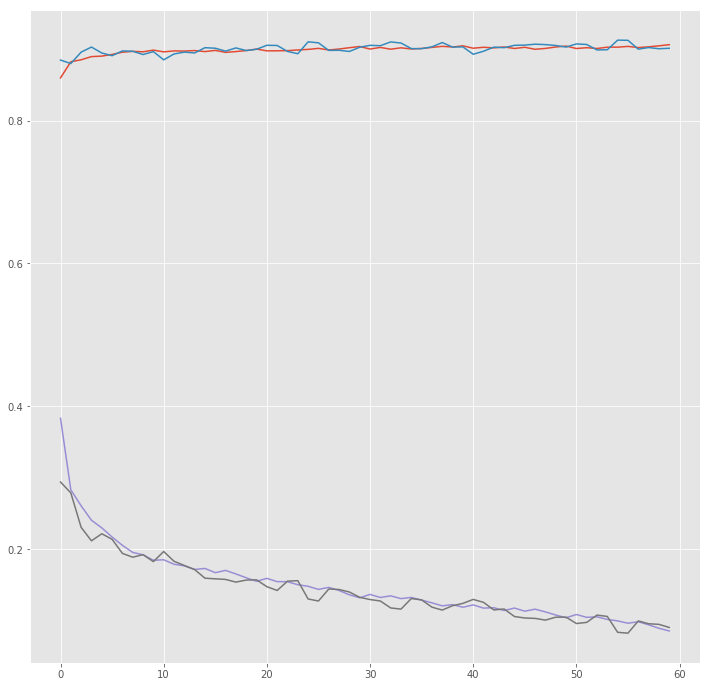

In [18]:
# plot
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist['crf_accuracy'])
plt.plot(hist['val_crf_accuracy'])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

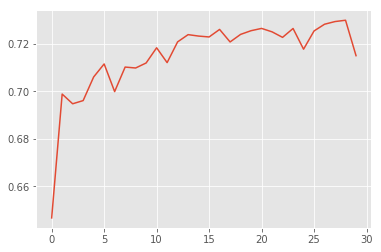

In [19]:
plt.plot(test_acc)
plt.show()

In [ ]:
model.model.load_weights('save_model/base_100n_1_5.h5')
for i in range(16):
    trainX, trainY = get_train(i)
    acc, _m, _marg = test_accuracy(trainX, trainY)
    print(i, acc, _m, _marg)

In [ ]:
print(train_texts[6729], train_tags[6729])

In [ ]:
with open('save_model/example_1.txt', 'w') as f:
    for line in train_texts[1315]:
        f.write(line + '\n')